
=== Neural Network ===
Predictions: [1, 0, 0, 1, 1, 0]
Confusion Matrix:
 [[3 0]
 [0 3]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



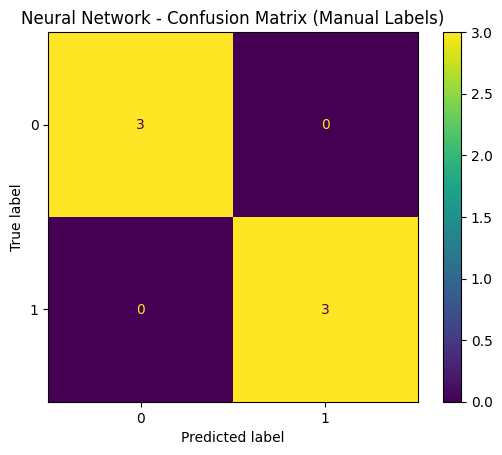


=== Random Forest ===
Predictions: [1, 0, 0, 1, 1, 0]
Confusion Matrix:
 [[3 0]
 [0 3]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



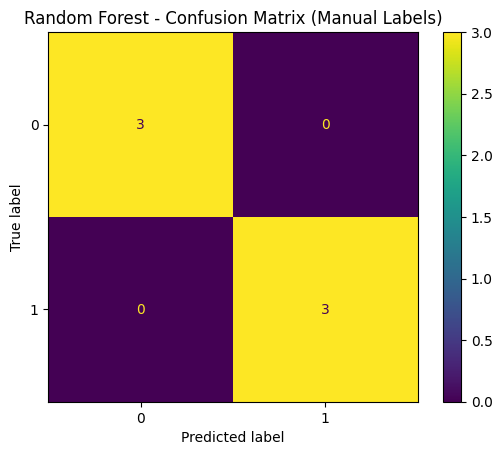


=== XGBoost ===
Predictions: [1, 0, 0, 1, 1, 0]
Confusion Matrix:
 [[3 0]
 [0 3]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



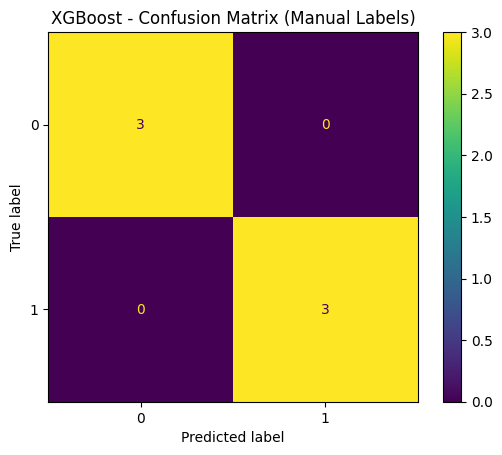


Final Dataset with Manual + Cluster Labels:
     trial  accuracy_percent  reaction_time_s  manual_label  cluster_label
0       1                98             0.92             1              0
1       2                95             1.05             1              0
2       3                92             1.20             1              0
3       4                85             1.75             0              1
4       5                88             1.40             0              0
5       6                76             2.10             0              1
6       7                81             1.95             0              1
7       8                90             1.30             0              0
8       9                94             1.10             1              0
9      10               100             0.85             1              0
10     11                67             2.45             0              1
11     12                73             2.00             0        

In [ ]:

# Step 0: Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Load data
data = {
    'trial': range(1,21),
    'accuracy_percent': [98,95,92,85,88,76,81,90,94,100,67,73,89,96,82,78,91,86,99,84],
    'reaction_time_s':[0.92,1.05,1.2,1.75,1.4,2.1,1.95,1.3,1.1,0.85,
                       2.45,2,1.6,0.98,1.85,2.05,1.25,1.55,0.88,1.7]
}
df = pd.DataFrame(data)

# Step 2a: Add Manual Label (Protect-2 Rule)
# Rule: accuracy >= 90 AND reaction_time <= 1.2 => Good (1), else Bad (0)
df["manual_label"] = df.apply(
    lambda row: 1 if (row["accuracy_percent"] >= 90 and row["reaction_time_s"] <= 1.2) else 0,
    axis=1
)

# Step 2b: Standardize features
X = df[['accuracy_percent','reaction_time_s']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: KMeans clustering (Protect-1)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['cluster_label'] = kmeans.fit_predict(X_scaled)

# Ensure cluster 0 = High performance, 1 = Low performance (based on centers)
centers = kmeans.cluster_centers_
if centers[0][0] > centers[1][0]:  # higher accuracy = high performance
    mapping = {0:0, 1:1}
else:
    mapping = {0:1, 1:0}
df['cluster_label'] = df['cluster_label'].map(mapping)

# Step 4: Train/Test split (using MANUAL LABEL for supervised learning Protect-2)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['manual_label'], 
                                                    test_size=0.3, random_state=42)

# Step 5a: Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(5,), max_iter=5000, learning_rate_init=0.001, random_state=42)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)

# Step 5b: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Step 5c: XGBoost
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Step 6: Display Confusion Matrices + Reports
models = {
    "Neural Network": (y_test, y_pred_nn),
    "Random Forest": (y_test, y_pred_rf),
    "XGBoost": (y_test, y_pred_xgb)
}

for name, (y_true, y_pred) in models.items():
    print(f"\n=== {name} ===")
    # Text output
    print("Predictions:", y_pred.tolist())
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    disp.plot(cmap='viridis')
    plt.title(f"{name} - Confusion Matrix (Manual Labels)")
    plt.show()

# Step 7: Show final dataset with both labels
print("\nFinal Dataset with Manual + Cluster Labels:\n", df)

# Step 8: Calculate Statistical Features (per MANUAL Label)
stats = df.groupby('manual_label').agg({
    'accuracy_percent': ['mean','median','std','min','max'],
    'reaction_time_s': ['mean','median','std','min','max']
}).reset_index()

print("\n=== Statistical Features per Manual Label ===\n", stats)


